In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from time import time
from matplotlib.animation import FuncAnimation 

Definimos las funciones que se invocarán que están en los otros archivos

In [2]:
def SystematicResampling(W):
    Np = len(W) 
    I = np.zeros(Np, dtype=int)
    if np.sum(W)==0:
        return I
    u = np.random.random()/Np 
    for i in range(Np):
        u_i = u + (i-1)/Np
        I[i] = np.where(W.cumsum()>=u_i)[0][0]
    return I

In [3]:
def MultinomialResampling(W):
    Np = len(W) 
    I = np.zeros(Np, dtype=int)
    if np.sum(W)==0:
        return I

    for i in range(Np):
        u = np.random.random()
        I[i] = np.where(W.cumsum()>=u)[0][0]
    return I

In [4]:
def NoResampling(W):
    return np.array(range(len(W)))

In [5]:
def SMC(Y, Np, Npop, p, p_obs, size, resampling_method = "multinomial"):
    # Set the resampling function 
    if resampling_method == "multinomial":
        resampler = MultinomialResampling
    elif resampling_method == "systematic":
        resampler = SystematicResampling
    else:
        resampler = NoResampling

    # Data length
    N = len(Y)
    # Array for particles
    Xp = np.zeros((Np, N, 2), dtype=int)
    # wp unnormalized weigths, Wp normalized weigths
    wp, Wp = np.zeros((Np, N)), np.zeros((Np, N))

    # Initial condition
    Xp[:,0,1] = stats.poisson(15).rvs()
    Xp[:,0,0] = Npop - Xp[:,0,1]

    # Negative binomial parameter p (probabily of success)
    param = size/(size + p_obs*Xp[:,0,1])

    # Weigths at first step
    wp[:,0] = stats.nbinom(size, param).pmf(Y[0]) 
    Wp[:,0] = wp[:,0]/np.sum(wp[:,0]) 

    # With resampling function generate an index array
    # to keep with high probability the particles with
    # higher weigths
    I = resampler(Wp[:,0]).astype(int)
    Xp = Xp[I,:,:].copy()

    # Repeat for all the data
    for i in range(1, N):          
        Xp[:,i,1] = stats.binom(Xp[:,i-1,0], 1-(1-p)**Xp[:,i-1,1]).rvs(Np)
        Xp[:,i,0] = Xp[:,i-1,0] - Xp[:,i,1]
        param = size/(size + p_obs*Xp[:,i,1])
        wp[:,i] = stats.nbinom(size, param).pmf(Y[i])
        Wp[:,i] = wp[:,i]/np.sum(wp[:,i])  
        I = resampler(Wp[:,i])
        Xp = Xp[I,:,:].copy()

    return Xp, wp

In [6]:
# Function that estimates the parameter of infection p
# Returns the sucesive iterations of the parameter and the 
# marginal likelihood
def PMCMC(Y, Np, iteraciones, warmup, Npop, p0, p_obs, size, resampling_method="multinomial", verbose=True):
    marginal_likelihood = np.zeros(iteraciones + warmup)
    p_estimate = np.zeros(iteraciones)
    p_estimate[0] = p0
    Xp, wp = SMC(Y, Np, Npop, p0, p_obs, size, resampling_method=resampling_method)
    marginal_likelihood[0] = np.prod(wp.sum(axis=0))

    if verbose:
        print("Warming up")
    for i in range(1, warmup):
        if verbose:
            if i%(int(warmup/10))==0:
                print(f"Chain number: {i} of {warmup}")
        p_prop = p_estimate[i-1] + stats.norm(0.00001, 10**(-5)).rvs()
        while p_prop <= 0:
            p_prop = p_estimate[i-1] + stats.norm(0.00001, 10**(-5)).rvs()
        q1 = stats.norm(p_prop + 0.00001, 10**(-5)).pdf(p_estimate[i-1])
        q2 = stats.norm(p_estimate[i-1] + 0.00001, 10**(-5)).pdf(p_prop)
        q1, q2 = 1, 1
        Xp, wp = SMC(Y, Np, Npop, p_prop, p_obs, size, resampling_method=resampling_method) 
        marginal_likelihood_prop = np.prod(wp.sum(axis=0))
        u = np.random.random() 
        if u < marginal_likelihood_prop*q1/(marginal_likelihood[i-1]*q2):
            p_estimate[i] = p_prop 
            marginal_likelihood[i] = marginal_likelihood_prop 
        else:
            p_estimate[i] = p_estimate[i-1] 
            marginal_likelihood[i] = marginal_likelihood[i-1]
    if verbose:
        print("")
        print("Effective iterations")
    for i in range(warmup,iteraciones):
        if verbose:
            if i%(int((iteraciones-warmup)/10))==0:
                print(f"Chain number: {i-warmup} of {iteraciones - warmup}")
        p_prop = p_estimate[i-1] + stats.norm(0.00001, 10**(-5)).rvs()
        while p_prop <= 0:
            p_prop = p_estimate[i-1] + stats.norm(0.00001, 10**(-5)).rvs()
        q1 = stats.norm(p_prop + 0.00001, 10**(-5)).pdf(p_estimate[i-1])
        q2 = stats.norm(p_estimate[i-1] + 0.00001, 10**(-5)).pdf(p_prop)
        #q1, q2 = 1, 1
        Xp, wp = SMC(Y, Np, Npop, p_prop, p_obs, size, resampling_method=resampling_method) 
        marginal_likelihood_prop = np.prod(wp.sum(axis=0))
        u = np.random.random() 
        if u < marginal_likelihood_prop*q1/(marginal_likelihood[i-1]*q2):
            p_estimate[i] = p_prop 
            marginal_likelihood[i] = marginal_likelihood_prop 
        else:
            p_estimate[i] = p_estimate[i-1] 
            marginal_likelihood[i] = marginal_likelihood[i-1]
    
    return marginal_likelihood, p_estimate

In [7]:
def simulatedReedFrost(Nsim, Npop, p, lambd, Nit): #estaba I0 donde esta el lambd
    #S0 = Npop - I0
    I0= stats.poisson(lambd).rvs()
    S0 = Npop - I0
    
    I = np.zeros((Nit, Nsim), dtype=int)
    S = np.zeros((Nit, Nsim), dtype=int)
    I[0,:], S[0,:] = I0, S0 
    for i in range(1,Nit):
        I[i] = stats.binom.rvs(S[i-1], 1 - (1-p)**I[i-1], size=Nsim)
        S[i] = S[i-1] - I[i]
    return (S,I)

In [8]:
def ReedFrostWithObs(Npop, p, p_obs, Nit, size, lambd):
    initial_I = stats.poisson(lambd).rvs()
    initial_S = Npop - initial_I
     
    S, I = simulatedReedFrost(1, Npop, p, initial_I, Nit)
    
    X = (S, I)
    param = size/(size + p_obs*I)
    Y = stats.nbinom(size, param).rvs()
    return (X, Y)

In [9]:
# Function that returns the mean path in particles obteined by SMC
# further more, return the 1 - alpha level confidence interval
def computeMeanPathRF(particleSet, alpha):
    Xp, wp = particleSet 
    N = len(Xp[0,:,0]) 
    mu_Xp = np.zeros((N,3))
    for i in range(N):
        mu_Xp[i,0] = np.sum(Xp[:,i,1]*wp[:,i])/np.sum(wp[:,i])
        q1, q2 = np.quantile(Xp[:,i,1],[alpha/2, 1 - alpha/2])
        mu_Xp[i,1] = q1
        mu_Xp[i,2] = q2
        
    return mu_Xp

# Resultados

Observemos primero un ejemplo concreto de la aplicación de este modelo para una población de 100 individuos, cuya población Inicial de infectados distribuye como una variable Poisson de parámetro 10.

Con respecto al uso de PMCMC, usaremos 10 particulas, un parámetro inicial de p=0.02 y para 20 iteraciones temporales

esto es pa comprender como se deberían portar las poblaciones si p=0.02??

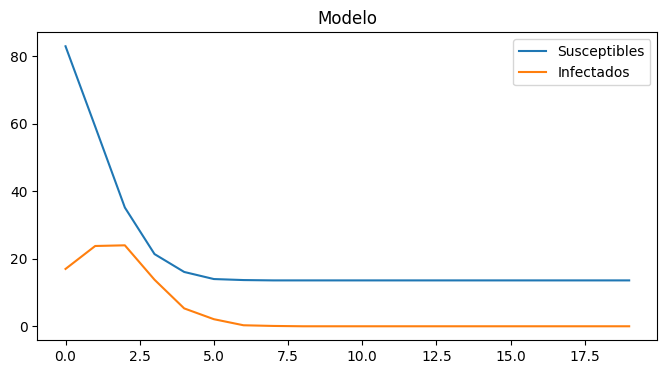

In [10]:
lambd      =15
Nparticles =10
Npopulation=100
p          =0.02
Niterations=20

S_sims, I_sims = simulatedReedFrost(Nparticles, Npopulation, p, lambd, Niterations)
#Nsim, Npop, p, lambd, Nit
S = np.mean(S_sims, axis=1) 
I = np.mean(I_sims, axis=1)

T = range(Niterations) 

plt.figure(figsize=(8,4))
plt.title("Modelo")
plt.plot(T,S, label="Susceptibles")
plt.plot(T,I, label="Infectados")
plt.legend()
plt.show()

Ahora estudiaremos como se va portando la estimación de casos si variamos el resampler

In [11]:
#Inicializamos los parámetros
lambd      = 15
Nparticles = 2000
Npopulation= 10000
p_0        = 0.00015
time_sim   = 40  
size       = 3
p_obs      = 0.05
Niterations= 300
warmup     = 50
alpha      = 0.05

X, Y = ReedFrostWithObs(Npopulation, p_0, p_obs, time_sim, size, lambd)

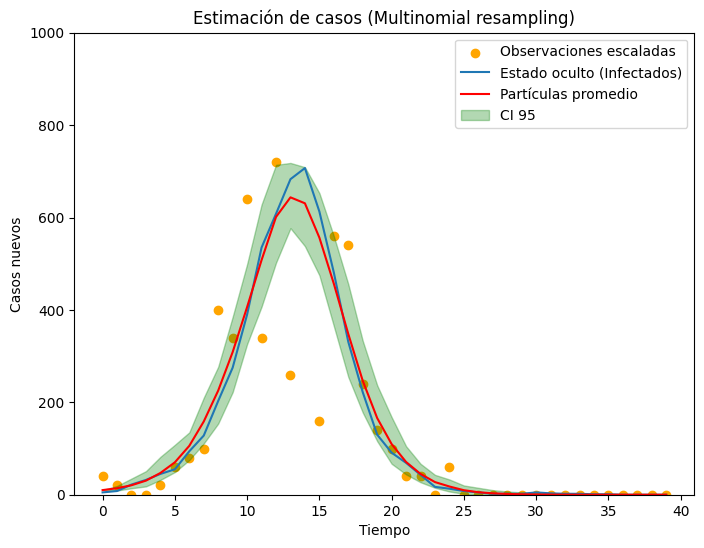

In [12]:
#primero con multinomial
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p_0, p_obs, size, resampling_method="multinomial")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title("Estimación de casos (Multinomial resampling)")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

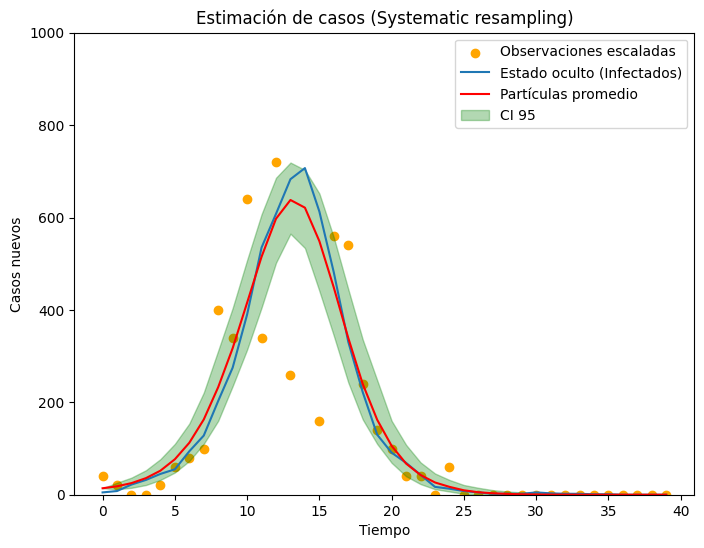

In [13]:
#ahora con systematic resampler
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p_0, p_obs, size, resampling_method="systematic")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title("Estimación de casos (Systematic resampling)")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

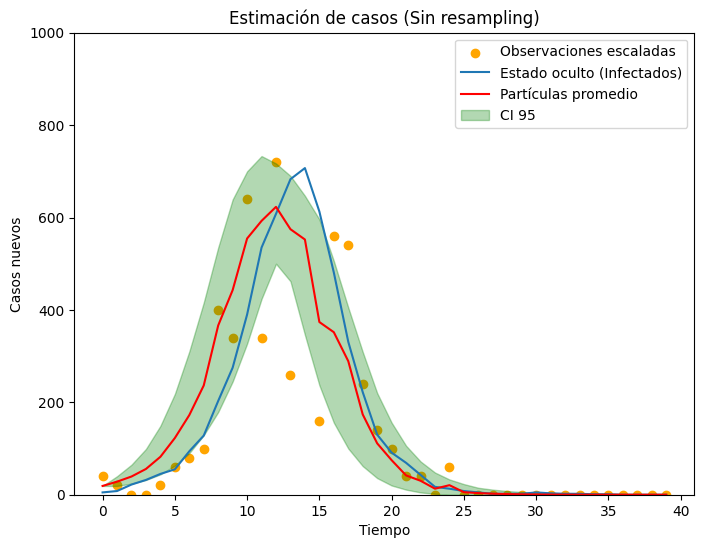

In [14]:
#Finalmente sin resampler
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p_0, p_obs, size, resampling_method="No resampler")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title("Estimación de casos (Sin resampling)")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

Estudiaremos ahora la convergencia del PMCMC

In [15]:
# p inicial para el método
p0 = 0.0001

# Multinomial resampling
print("Multinomial resampling:")
ini_time = time()
marginal_likelihood, p_estimate_1 = PMCMC(Y, Nparticles, Niterations, warmup, Npopulation, p0, p_obs, size, resampling_method="multinomial")
end_time = time()
print("Fin multinomial resampling")
print(f"Tiempo multinomial resampling: {end_time - ini_time}")
print()

# Systematic resampling
print("Systematic resampling")
ini_time = time()
marginal_likelihood, p_estimate_2 = PMCMC(Y, Nparticles, Niterations, warmup, Npopulation, p0, p_obs, size, resampling_method="systematic")
end_time = time()
print("Fin systematic resampling")
print(f"Tiempo systematic resampling: {end_time - ini_time}")
print()

# Sin resampling
print("Sin resampling")
ini_time = time()
marginal_likelihood, p_estimate_3 = PMCMC(Y, Nparticles, Niterations, warmup, Npopulation, p0, p_obs, size, resampling_method="No resampler")
end_time = time()
print("Fin sin resampling")
print(f"Tiempo sin resampling: {end_time - ini_time}")

Multinomial resampling:
Warming up
Chain number: 5 of 50
Chain number: 10 of 50
Chain number: 15 of 50
Chain number: 20 of 50
Chain number: 25 of 50
Chain number: 30 of 50
Chain number: 35 of 50
Chain number: 40 of 50
Chain number: 45 of 50

Effective iterations
Chain number: 0 of 250
Chain number: 25 of 250
Chain number: 50 of 250
Chain number: 75 of 250
Chain number: 100 of 250
Chain number: 125 of 250
Chain number: 150 of 250
Chain number: 175 of 250
Chain number: 200 of 250
Chain number: 225 of 250
Fin multinomial resampling
Tiempo multinomial resampling: 433.2935347557068

Systematic resampling
Warming up
Chain number: 5 of 50
Chain number: 10 of 50
Chain number: 15 of 50
Chain number: 20 of 50
Chain number: 25 of 50
Chain number: 30 of 50
Chain number: 35 of 50
Chain number: 40 of 50
Chain number: 45 of 50

Effective iterations
Chain number: 0 of 250
Chain number: 25 of 250
Chain number: 50 of 250
Chain number: 75 of 250
Chain number: 100 of 250
Chain number: 125 of 250
Chain num

In [16]:
p1 = p_estimate_1[warmup:].mean()
p1_CI = np.quantile(p_estimate_1[warmup:], [0.025, 0.975])

p2 = p_estimate_2[warmup:].mean()
p2_CI = np.quantile(p_estimate_2[warmup:], [0.025, 0.975])

p3 = p_estimate_3[warmup:].mean()
p3_CI = np.quantile(p_estimate_3[warmup:], [0.025, 0.975])

print("Multinomial resampling:")
print(f"p estimado: {p1} ({p1_CI[0]}, {p1_CI[1]})")

print("Systematic resampling:")
print(f"p estimado: {p2} ({p2_CI[0]}, {p2_CI[1]})")

print("Sin resampling:")
print(f"p estimado: {p3} ({p3_CI[0]}, {p3_CI[1]})")

Multinomial resampling:
p estimado: 0.0001531505898483745 (0.0001419422114664111, 0.0001622112720696347)
Systematic resampling:
p estimado: 0.00015508372832572564 (0.0001464447537847235, 0.00016543973372685702)
Sin resampling:
p estimado: 0.00015040843752385104 (0.00014378787211165238, 0.00015669331752295117)


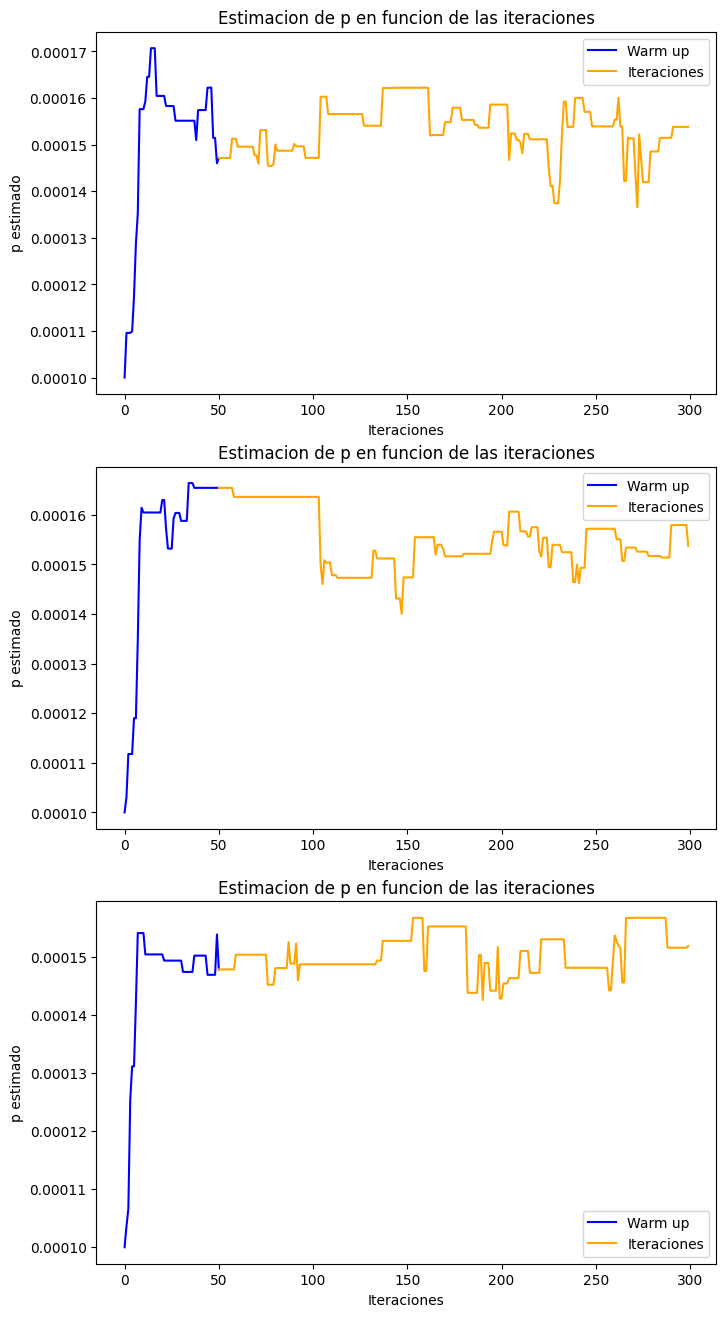

In [17]:
colores=['blue', 'green', 'red', 'black']

beta=[p_estimate_1, p_estimate_2, p_estimate_3]

plt.figure( figsize=(8,16))
for i in range(1,4):
    x1= range(warmup+1)
    x2= range(warmup,Niterations)
    y = beta[i-1]
    ax=plt.subplot(3,1,i)
    ax.plot(x1,y[:warmup+1], color="blue", label="Warm up")
    ax.plot(x2,y[warmup:Niterations], color="orange", label="Iteraciones")
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('p estimado')
    ax.set_title('Estimacion de p en funcion de las iteraciones')
    ax.legend()
plt.show()

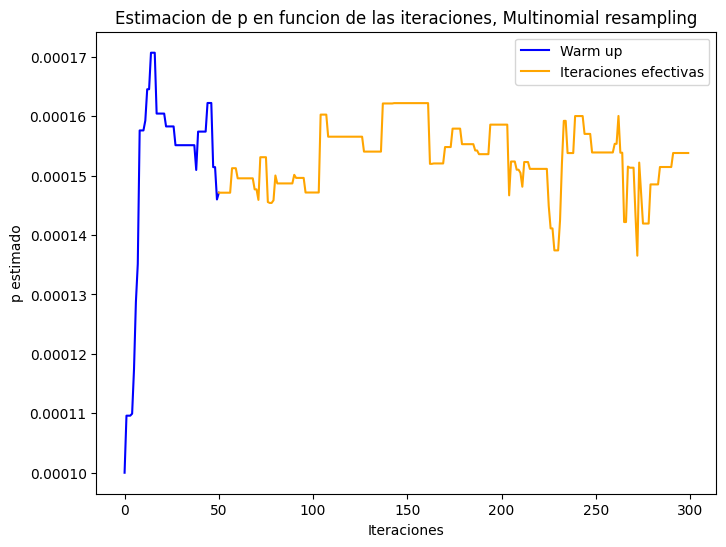

In [18]:
colores=['blue', 'green', 'red', 'black']

beta=[p_estimate_1, p_estimate_2, p_estimate_3]

x1= range(warmup+1)
x2= range(warmup,Niterations)
y = p_estimate_1

plt.figure(figsize=(8,6))
plt.plot(x1,y[:warmup+1], color="blue", label="Warm up")
plt.plot(x2,y[warmup:Niterations], color="orange", label="Iteraciones efectivas")
plt.xlabel('Iteraciones')
plt.ylabel('p estimado')
plt.title('Estimacion de p en funcion de las iteraciones, Multinomial resampling')
plt.legend()
plt.show()

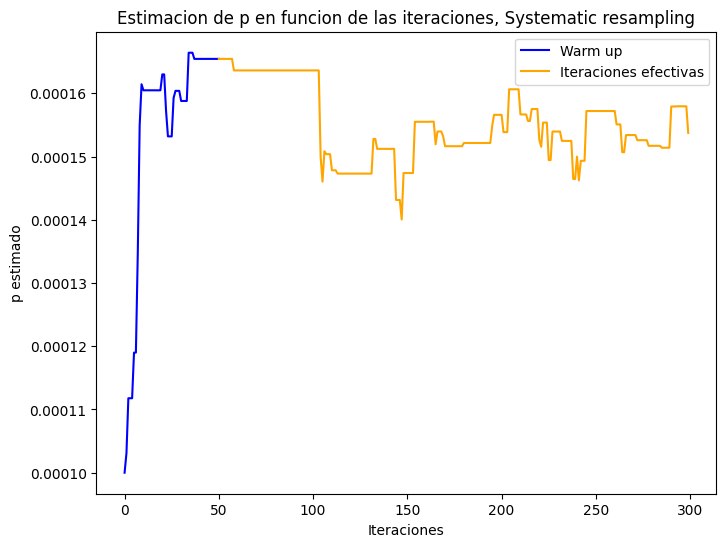

In [19]:
x1= range(warmup+1)
x2= range(warmup,Niterations)
y = p_estimate_2

plt.figure(figsize=(8,6))
plt.plot(x1,y[:warmup+1], color="blue", label="Warm up")
plt.plot(x2,y[warmup:Niterations], color="orange", label="Iteraciones efectivas")
plt.xlabel('Iteraciones')
plt.ylabel('p estimado')
plt.title('Estimacion de p en funcion de las iteraciones, Systematic resampling')
plt.legend()
plt.show()

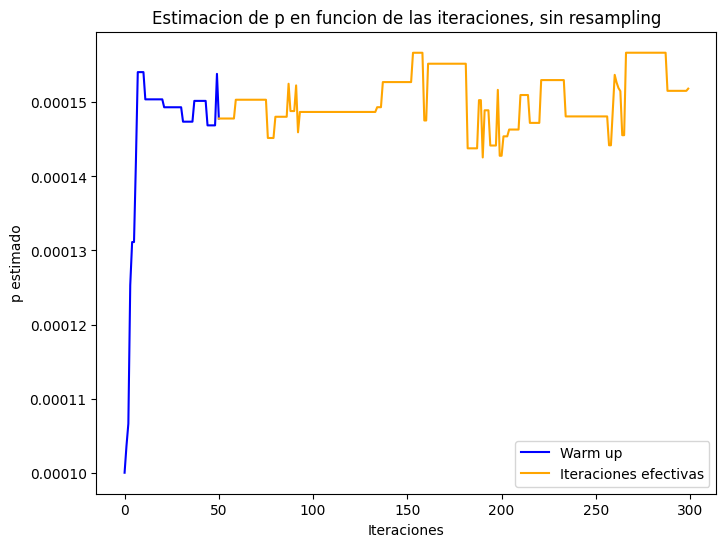

In [20]:
x1= range(warmup+1)
x2= range(warmup,Niterations)
y = p_estimate_3

plt.figure(figsize=(8,6))
plt.plot(x1,y[:warmup+1], color="blue", label="Warm up")
plt.plot(x2,y[warmup:Niterations], color="orange", label="Iteraciones efectivas")
plt.xlabel('Iteraciones')
plt.ylabel('p estimado')
plt.title('Estimacion de p en funcion de las iteraciones, sin resampling')
plt.legend()
plt.show()

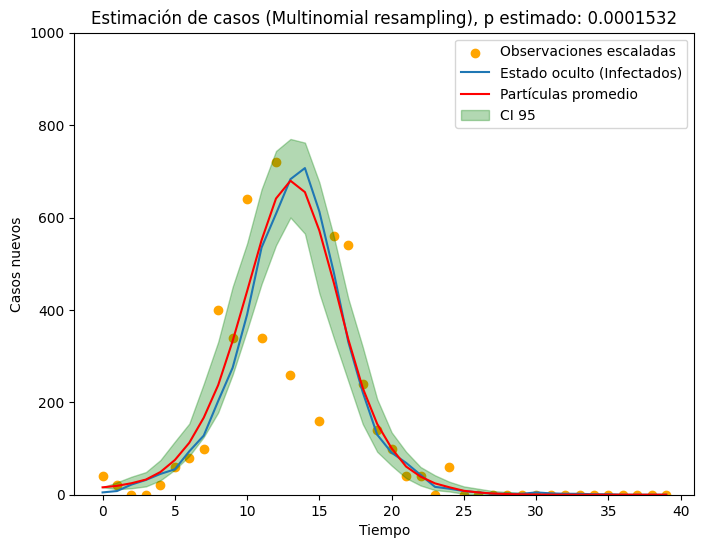

In [21]:
#primero con multinomial
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p1, p_obs, size, resampling_method="multinomial")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)
ec = 0
for i in range(time_sim):
    ec += (X[:][1][i] - mu_Xp[:,0][i])**2 
ecm1 = ec[0]/time_sim

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title(f"Estimación de casos (Multinomial resampling), p estimado: {p1.round(7)}")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

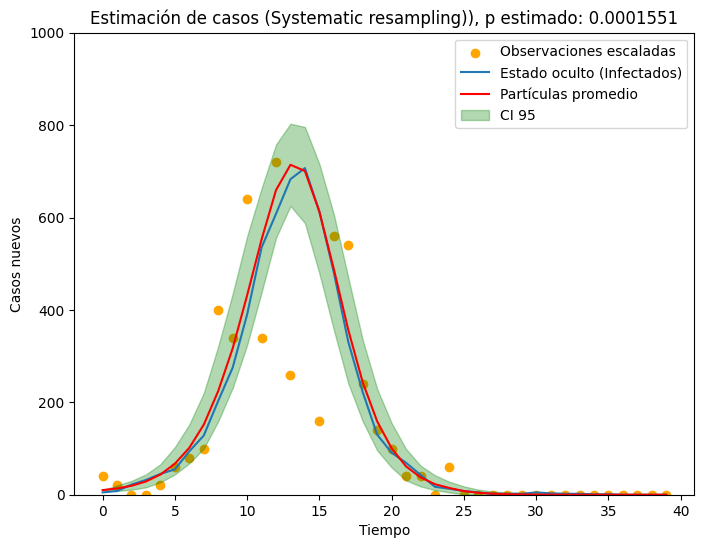

In [22]:
#ahora con systematic resampler
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p2, p_obs, size, resampling_method="systematic")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)
ec = 0
for i in range(time_sim):
    ec += (X[:][1][i] - mu_Xp[:,0][i])**2 
ecm2 = ec[0]/time_sim

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title(f"Estimación de casos (Systematic resampling)), p estimado: {p2.round(7)}")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

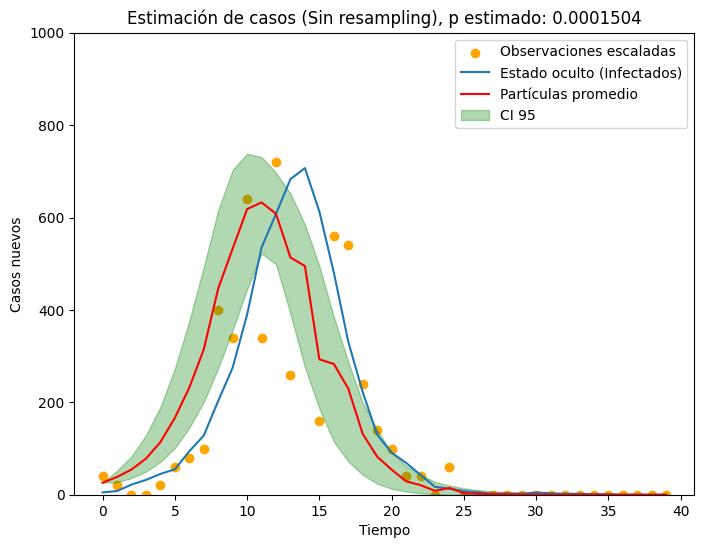

In [23]:
#Finalmente sin resampler
filter_particlesRF = SMC(Y, Nparticles, Npopulation, p3, p_obs, size, resampling_method="No resampler")
mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)
ec = 0
for i in range(time_sim):
    ec += (X[:][1][i] - mu_Xp[:,0][i])**2 
ecm3 = ec[0]/time_sim

plt.figure(figsize=(8,6))
plt.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
plt.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
plt.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
plt.ylim(0,1000)  
plt.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
plt.title(f"Estimación de casos (Sin resampling), p estimado: {p3.round(7)}")
plt.xlabel("Tiempo")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

In [24]:
print("Mean squared error:")
print(f"Multinomial: {ecm1}")
print(f"Systematic: {ecm2}")
print(f"No Resampling: {ecm3}")

Mean squared error:
Multinomial: 420.23461639536225
Systematic: 273.76799684614144
No Resampling: 12555.276166549007


Resultados: estudiaremos como se comportan para diferentes valores de p_initial, diferentes iteraciones, diferente cantidad de particulas del método, asi como también para distintos resamplers

MovieWriter ffmpeg unavailable; using Pillow instead.


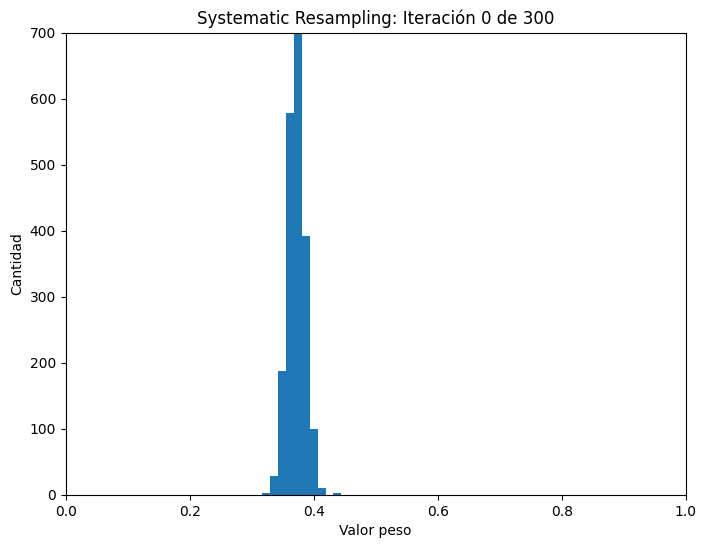

In [25]:
 # initializing a figure in 
# which the graph will be plotted
fig = plt.figure(figsize=(8,6)) 
   
# marking the x-axis and y-axis
ax = fig.add_subplot(1,1,1)
  
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    p = p_estimate_2[i]
    Xp, wp = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="systematic")
    ax.clear()
    ax.hist(wp.mean(axis=1))
    ax.set_xlim(0,1)
    ax.set_ylim(0,700)
    ax.set_xlabel("Valor peso")
    ax.set_ylabel("Cantidad")
    ax.set_title(f"Systematic Resampling: Iteración {i} de {Niterations}")

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('SystematicWeigths.gif', fps = int(Niterations/15))

MovieWriter ffmpeg unavailable; using Pillow instead.


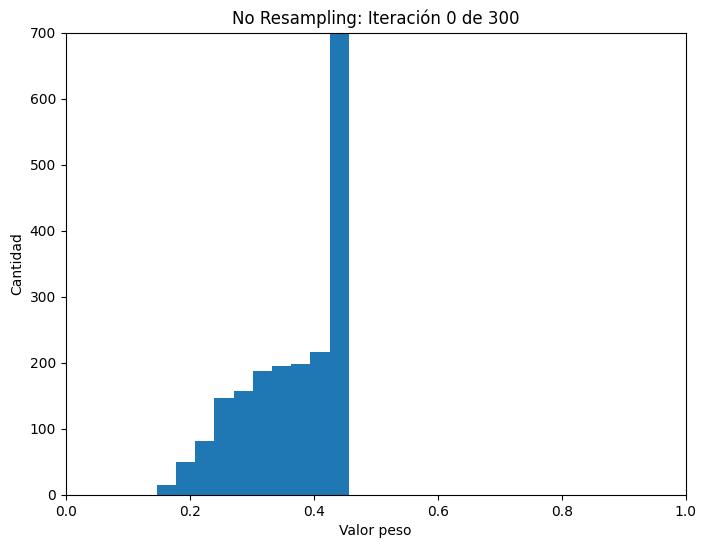

In [26]:
 # initializing a figure in 
# which the graph will be plotted
fig = plt.figure(figsize=(8,6)) 
   
# marking the x-axis and y-axis
ax = fig.add_subplot(1,1,1)
  
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    p = p_estimate_3[i]
    Xp, wp = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="")
    ax.clear()
    ax.hist(wp.mean(axis=1))
    ax.set_xlim(0,1)
    ax.set_ylim(0,700)
    ax.set_xlabel("Valor peso")
    ax.set_ylabel("Cantidad")
    ax.set_title(f"No Resampling: Iteración {i} de {Niterations}")

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('NoResamplingWeigths.gif', fps = int(Niterations/15))

MovieWriter ffmpeg unavailable; using Pillow instead.


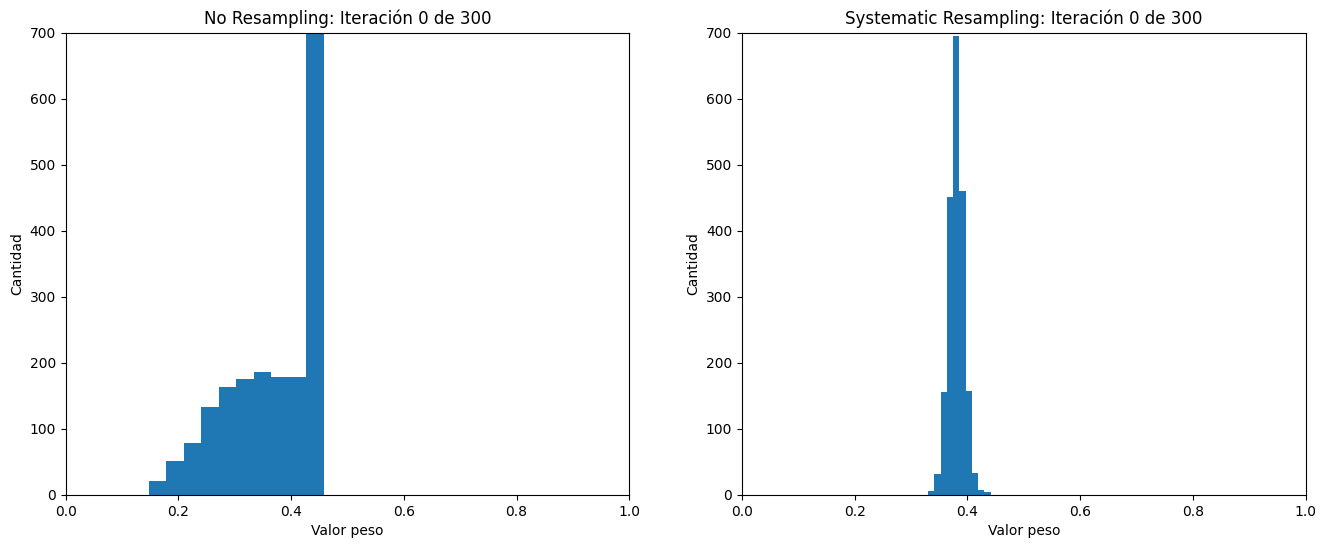

In [27]:
 # initializing a figure in 
# which the graph will be plotted
fig, ax = plt.subplots(1,2, figsize=(16,6)) 
   
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    ax[0].clear()
    ax[1].clear()
    p = p_estimate_3[i]
    Xp, wp = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="")
    ax[0].clear()
    ax[0].hist(wp.mean(axis=1))
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,700)
    ax[0].set_xlabel("Valor peso")
    ax[0].set_ylabel("Cantidad")
    ax[0].set_title(f"No Resampling: Iteración {i} de {Niterations}")

    p = p_estimate_2[i]
    Xp, wp = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="systematic")
    ax[1].clear()
    ax[1].hist(wp.mean(axis=1))
    ax[1].set_xlim(0,1)
    ax[1].set_ylim(0,700)
    ax[1].set_xlabel("Valor peso")
    ax[1].set_ylabel("Cantidad")
    ax[1].set_title(f"Systematic Resampling: Iteración {i} de {Niterations}")

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('WeigthsCompar.gif', fps = int(Niterations/20))

MovieWriter ffmpeg unavailable; using Pillow instead.


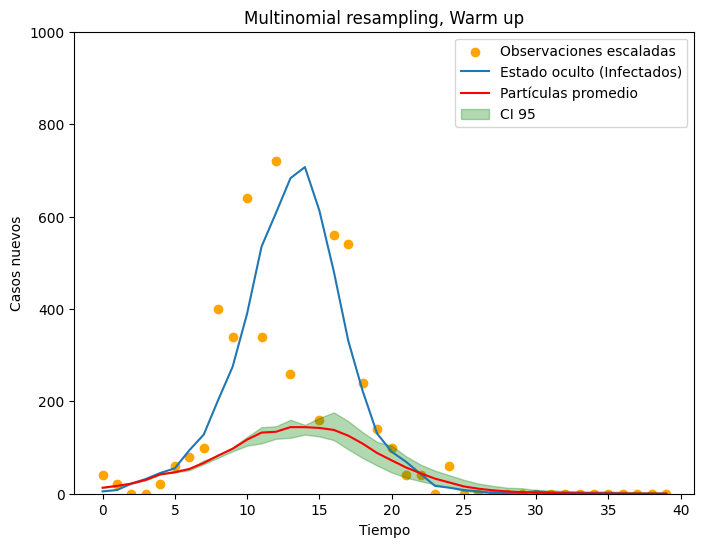

In [28]:
 # initializing a figure in 
# which the graph will be plotted
fig = plt.figure(figsize=(8,6)) 
   
# marking the x-axis and y-axis
ax = fig.add_subplot(1,1,1)
  
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):

    ax.clear()
    p = p_estimate_2[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="multinomial")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax.set_ylim(0,1000)  
    ax.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax.set_title("Multinomial resampling, Warm up")
    else:
        ax.set_title(f"Multinomial resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Casos nuevos")
    plt.legend()

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('Multinomial.gif', fps = 10)

MovieWriter ffmpeg unavailable; using Pillow instead.


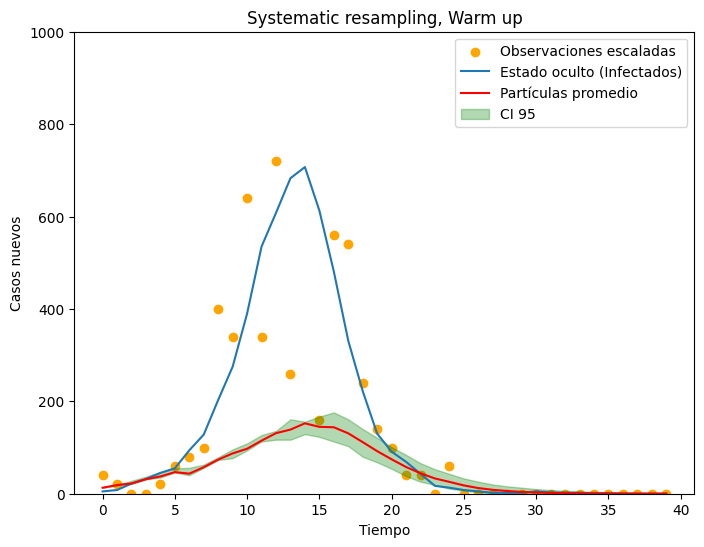

In [29]:
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure(figsize=(8,6)) 
   
# marking the x-axis and y-axis
ax = fig.add_subplot(1,1,1)
  
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):

    ax.clear()
    p = p_estimate_2[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="systematic")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax.set_ylim(0,1000)  
    ax.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax.set_title("Systematic resampling, Warm up")
    else:
        ax.set_title(f"Systematic resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Casos nuevos")
    plt.legend()

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('Systematic.gif', fps = int(Niterations/10))

MovieWriter ffmpeg unavailable; using Pillow instead.


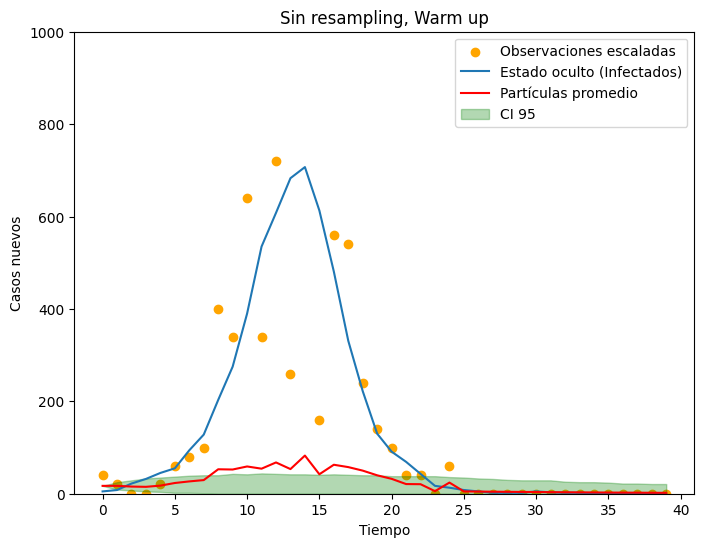

In [30]:
 # initializing a figure in 
# which the graph will be plotted
fig = plt.figure(figsize=(8,6)) 
   
# marking the x-axis and y-axis
ax = fig.add_subplot(1,1,1)
  
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):

    ax.clear()
    p = p_estimate_2[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax.scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax.plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax.plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax.set_ylim(0,1000)  
    ax.fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax.set_title("Sin resampling, Warm up")
    else:
        ax.set_title(f"Sin resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Casos nuevos")
    plt.legend()

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('NoResampling.gif', fps = 10)

MovieWriter ffmpeg unavailable; using Pillow instead.


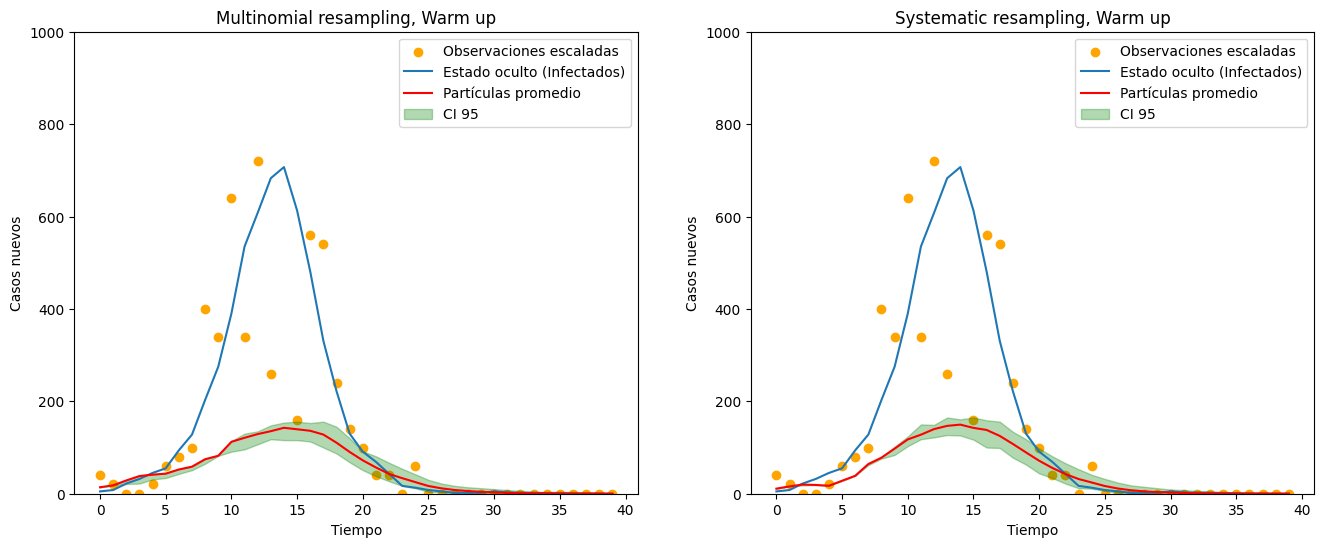

In [31]:
 # initializing a figure in 
# which the graph will be plotted
fig, ax = plt.subplots(1,2, figsize=(16,6)) 
   
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    ax[0].clear()
    ax[1].clear()
    p = p_estimate_1[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="multinomial")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax[0].scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax[0].plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax[0].plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax[0].set_ylim(0,1000)  
    ax[0].fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax[0].set_title("Multinomial resampling, Warm up")
    else:
        ax[0].set_title(f"Multinomial resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax[0].set_xlabel("Tiempo")
    ax[0].set_ylabel("Casos nuevos")
    ax[0].legend()

    p = p_estimate_2[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="systematic")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax[1].scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax[1].plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax[1].plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax[1].set_ylim(0,1000)  
    ax[1].fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax[1].set_title("Systematic resampling, Warm up")
    else:
        ax[1].set_title(f"Systematic resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax[1].set_xlabel("Tiempo")
    ax[1].set_ylabel("Casos nuevos")
    ax[1].legend()

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('MultinomialvsSystematic.gif', fps = int(Niterations/10))

MovieWriter ffmpeg unavailable; using Pillow instead.


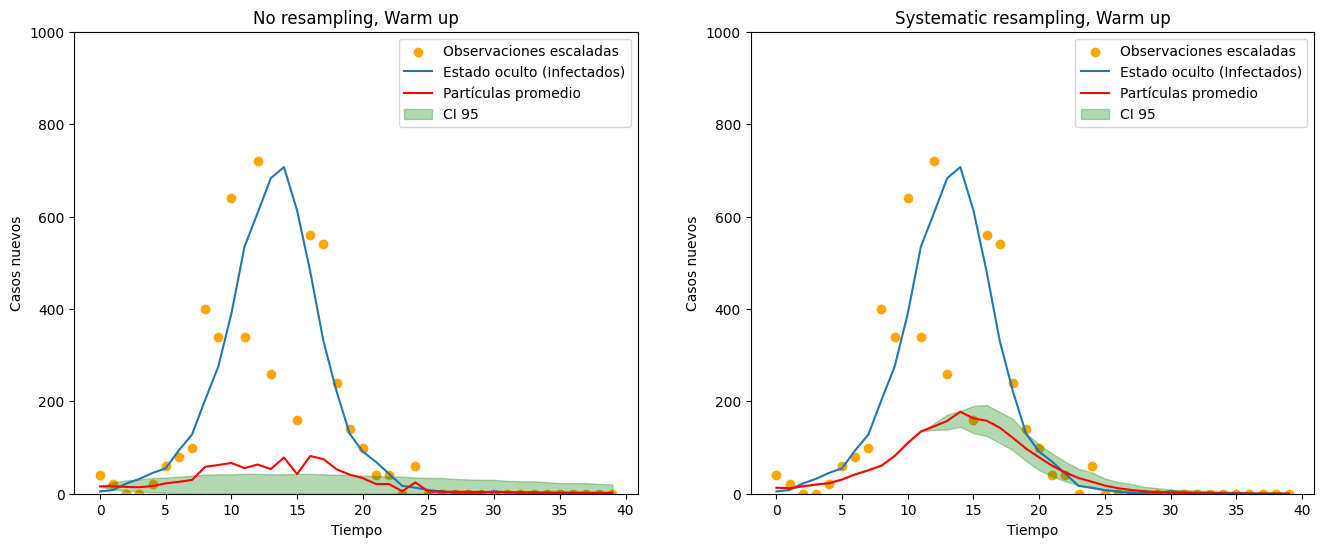

In [32]:
 # initializing a figure in 
# which the graph will be plotted
fig, ax = plt.subplots(1,2, figsize=(16,6)) 
   
# initializing a line variable
#line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    ax[0].clear()
    ax[1].clear()
    p = p_estimate_1[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax[0].scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax[0].plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax[0].plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax[0].set_ylim(0,1000)  
    ax[0].fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax[0].set_title("No resampling, Warm up")
    else:
        ax[0].set_title(f"No resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax[0].set_xlabel("Tiempo")
    ax[0].set_ylabel("Casos nuevos")
    ax[0].legend()

    p = p_estimate_2[i]
    filter_particlesRF = SMC(Y, Nparticles, Npopulation, p, p_obs, size, resampling_method="systematic")
    mu_Xp = computeMeanPathRF(filter_particlesRF, alpha)

    #plt.figure(figsize=(8,6))
    ax[1].scatter(np.array(range(len(Y))), Y/p_obs, label="Observaciones escaladas", c="orange")
    ax[1].plot(range(len(X[:][1])), X[:][1], label="Estado oculto (Infectados)")
    ax[1].plot(range(len(mu_Xp[:,0])), mu_Xp[:,0], color="red", label="Partículas promedio")
    ax[1].set_ylim(0,1000)  
    ax[1].fill_between(range(len(mu_Xp[:,1])), mu_Xp[:,1], mu_Xp[:,2], color="green", alpha=0.3, label="CI 95")
    if i <= warmup:
        ax[1].set_title("Systematic resampling, Warm up")
    else:
        ax[1].set_title(f"Systematic resampling, iteración {i-warmup}/{Niterations-warmup}")
    ax[1].set_xlabel("Tiempo")
    ax[1].set_ylabel("Casos nuevos")
    ax[1].legend()

anim = FuncAnimation(fig, animate, frames = Niterations)
  
anim.save('NoResamplingvsSystematic.gif', fps = int(Niterations/20))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5e0fc8d6-78ad-425d-ae75-e4277a0eb228' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>